# Predicting future demand

The predict cycle takes as input the model generated in the [data analysis](./data-analysis.ipynb) stage. 

Using the transition rates and new entry rates as well as a starting population, the model iterates day-by-day to see how the population changes over time. 

We start off by calculating our population statistics:

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
from cs_demand_model import Config, DemandModellingDataContainer, ModelPredictor, PopulationStats, fs_datastore

config = Config()
datastore = fs_datastore("sample://v1.zip")
dc = DemandModellingDataContainer(datastore, config)
stats = PopulationStats(dc.enriched_view, config)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Failed to read file DataFile(name='2017/placed_for_adoption.csv', metadata=Metadata(name='placed_for_adoption.csv', size=1, year=2017, table=None)): File is empty
Failed to read file DataFile(name='2017/ad1.csv', metadata=Metadata(name='ad1.csv', size=1, year=2017, table=None)): File is empty
Failed to read file DataFile(name='2019/placed_for_adoption.csv', metadata=Metadata(name='placed_for_adoption.csv', size=1, year=2019, table=None)): File is empty
Failed to read file DataFile(name='2019/ad1.csv', metadata=Metadata(name='ad1.csv', size=1, year=2019, table=None)): File is empty
Failed to read file DataFile(name='2021/placed_for_adoption.csv', metadata=Metadata(name='placed_for_adoption.csv', size=1, year=2021, table=None)): File is empty
Failed to read file DataFile(name='2021/ad1.csv', metadata=Metadata(name='ad1.csv', size=1, year=2021, table=None)): File is empty
Failed to read file DataFile(name='2020/placed_for_adoption.csv', metadata=Metadata(name='placed_for_adoption.csv', si

Created datastore with [DataFile(name='2017/header.csv', metadata=Metadata(name='header.csv', size=33527, year=None, table=<SSDA903TableType.HEADER: <cs_demand_model.data.ssda903.Header object at 0x11e480280>>)), DataFile(name='2017/episodes.csv', metadata=Metadata(name='episodes.csv', size=103508, year=2018, table=<SSDA903TableType.EPISODES: <cs_demand_model.data.ssda903.Episodes object at 0x11e480310>>)), DataFile(name='2019/header.csv', metadata=Metadata(name='header.csv', size=14844, year=None, table=<SSDA903TableType.HEADER: <cs_demand_model.data.ssda903.Header object at 0x11e480280>>)), DataFile(name='2019/episodes.csv', metadata=Metadata(name='episodes.csv', size=46259, year=2020, table=<SSDA903TableType.EPISODES: <cs_demand_model.data.ssda903.Episodes object at 0x11e480310>>)), DataFile(name='2021/header.csv', metadata=Metadata(name='header.csv', size=5928, year=None, table=<SSDA903TableType.HEADER: <cs_demand_model.data.ssda903.Header object at 0x11e480280>>)), DataFile(name='

In [2]:
stats.stock.tail()

bin,"(FIVE_TO_TEN, FOSTERING)","(FIVE_TO_TEN, OTHER)","(FIVE_TO_TEN, RESIDENTIAL)","(SIXTEEN_TO_EIGHTEEN, FOSTERING)","(SIXTEEN_TO_EIGHTEEN, OTHER)","(SIXTEEN_TO_EIGHTEEN, RESIDENTIAL)","(SIXTEEN_TO_EIGHTEEN, SUPPORTED)","(TEN_TO_SIXTEEN, FOSTERING)","(TEN_TO_SIXTEEN, OTHER)","(TEN_TO_SIXTEEN, RESIDENTIAL)","(TEN_TO_SIXTEEN, SUPPORTED)"
date,,,,,,,,,,,
2022-03-23,0.0,0.0,0.0,5.0,2.0,2.0,9.0,49.0,9.0,10.0,0.0
2022-03-24,0.0,0.0,0.0,5.0,2.0,2.0,9.0,49.0,9.0,10.0,0.0
2022-03-25,0.0,0.0,0.0,5.0,2.0,2.0,9.0,50.0,8.0,10.0,0.0
2022-03-26,0.0,0.0,0.0,5.0,2.0,2.0,9.0,50.0,8.0,10.0,0.0
2022-03-27,0.0,0.0,0.0,5.0,2.0,2.0,9.0,50.0,8.0,10.0,0.0


In [3]:
from datetime import date
stats.raw_transition_rates(date(2019,7,1), date(2020,1,1))

start_bin                           end_bin                           
(FIVE_TO_TEN, FOSTERING)            (FIVE_TO_TEN, FOSTERING)              0.002984
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.000615
                                    (FIVE_TO_TEN, OTHER)                  0.000180
                                    (FIVE_TO_TEN, RESIDENTIAL)            0.000270
(FIVE_TO_TEN, OTHER)                (FIVE_TO_TEN, FOSTERING)              0.000000
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.000000
                                    (FIVE_TO_TEN, OTHER)                  0.005405
                                    (FIVE_TO_TEN, RESIDENTIAL)            0.000000
(FIVE_TO_TEN, RESIDENTIAL)          (FIVE_TO_TEN, FOSTERING)              0.000000
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.001351
                                    (FIVE_TO_TEN, OTHER)                  0.000000
                

From this we can now run a model prediction to see how the population evolves. 
As we covered in the data analysis documentation, we need to provide a start and end date for the analysis window.

In [4]:
start_date, end_date = pd.to_datetime('2019-07-01'), pd.to_datetime('2020-01-01')
predictor = ModelPredictor.from_model(stats, start_date, end_date)

The predictor is an iterative model that has a state and can return the predictor for the next period. 

To see the current population, in this case the starting population from the model, view the `initial_population`:

In [5]:
predictor.initial_population

bin
(FIVE_TO_TEN, FOSTERING)               23.0
(FIVE_TO_TEN, OTHER)                    0.0
(FIVE_TO_TEN, RESIDENTIAL)              3.0
(SIXTEEN_TO_EIGHTEEN, FOSTERING)        9.0
(SIXTEEN_TO_EIGHTEEN, OTHER)            7.0
(SIXTEEN_TO_EIGHTEEN, RESIDENTIAL)      1.0
(SIXTEEN_TO_EIGHTEEN, SUPPORTED)       14.0
(TEN_TO_SIXTEEN, FOSTERING)           130.0
(TEN_TO_SIXTEEN, OTHER)                23.0
(TEN_TO_SIXTEEN, RESIDENTIAL)          31.0
(TEN_TO_SIXTEEN, SUPPORTED)             0.0
Name: 2020-01-01 00:00:00, dtype: float64

In [6]:
predictor.transition_rates

from                                to                                
(FIVE_TO_TEN, FOSTERING)            (FIVE_TO_TEN, FOSTERING)              0.002984
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.000615
                                    (FIVE_TO_TEN, OTHER)                  0.000180
                                    (FIVE_TO_TEN, RESIDENTIAL)            0.000270
(FIVE_TO_TEN, OTHER)                (FIVE_TO_TEN, FOSTERING)              0.000000
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.000000
                                    (FIVE_TO_TEN, OTHER)                  0.005405
                                    (FIVE_TO_TEN, RESIDENTIAL)            0.000000
(FIVE_TO_TEN, RESIDENTIAL)          (FIVE_TO_TEN, FOSTERING)              0.000000
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.001351
                                    (FIVE_TO_TEN, OTHER)                  0.000000
                

In [7]:
tn, tr = predictor.transition_numbers.align(predictor.transition_rates)
tn.fillna(0) + tr.fillna(0)

from                                to                                
()                                  (FIVE_TO_TEN, FOSTERING)              0.005435
                                    (TEN_TO_SIXTEEN, FOSTERING)           0.021739
(FIVE_TO_TEN, FOSTERING)            (FIVE_TO_TEN, FOSTERING)              0.002984
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.000615
                                    (FIVE_TO_TEN, OTHER)                  0.000180
                                    (FIVE_TO_TEN, RESIDENTIAL)            0.000270
(FIVE_TO_TEN, OTHER)                (FIVE_TO_TEN, FOSTERING)              0.000000
                                    (FIVE_TO_TEN, NOT_IN_CARE)            0.000000
                                    (FIVE_TO_TEN, OTHER)                  0.005405
                                    (FIVE_TO_TEN, RESIDENTIAL)            0.000000
(FIVE_TO_TEN, RESIDENTIAL)          (FIVE_TO_TEN, FOSTERING)              0.000000
                

We can now ask for the next population:

In [8]:
predictor = predictor.next()
predictor.initial_population

from
(FIVE_TO_TEN, FOSTERING)               22.980929
(FIVE_TO_TEN, OTHER)                    0.004144
(FIVE_TO_TEN, RESIDENTIAL)              3.002166
(SIXTEEN_TO_EIGHTEEN, FOSTERING)        8.984847
(SIXTEEN_TO_EIGHTEEN, OTHER)            6.985132
(SIXTEEN_TO_EIGHTEEN, RESIDENTIAL)      0.994399
(SIXTEEN_TO_EIGHTEEN, SUPPORTED)       13.954860
(TEN_TO_SIXTEEN, FOSTERING)           129.740332
(TEN_TO_SIXTEEN, OTHER)                23.003749
(TEN_TO_SIXTEEN, RESIDENTIAL)          30.999384
(TEN_TO_SIXTEEN, SUPPORTED)             0.033940
Name: 2020-01-02 00:00:00, dtype: float64

You can run the above block multiple times to see the population change. To reset, go back and create a new predictor from the initial state. 

Since we usually want to run multiple iterations in one simple operations, there is also a utility method on the predictor to run *n* generations and return a dataframe of all the populations. You can add progress=True to get a progress bar so you have something to enjoy watching while you make a cup of tea...

In [40]:
start_date, end_date = pd.to_datetime('2019-07-01'), pd.to_datetime('2020-01-01')

predictor = ModelPredictor.from_model(stats, start_date, end_date)
predicted_pop = predictor.predict(72, progress=True, step_days=10)  # Predict 720 days forward
historic_pop = stats.stock.loc[:end_date]
combined_pop = pd.concat([historic_pop, predicted_pop], axis=0)
combined_pop.columns = pd.MultiIndex.from_tuples(combined_pop.columns)

# Remove this to see individual sequences
combined_pop = combined_pop.groupby(level=1, axis=1).sum()
combined_pop

2021-12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 52.71it/s]


,FOSTERING,OTHER,RESIDENTIAL,SUPPORTED
2013-08-27,0.000000,1.000000,0.000000,0.000000
2013-08-28,0.000000,1.000000,0.000000,0.000000
2013-08-29,0.000000,1.000000,0.000000,0.000000
2013-08-30,0.000000,1.000000,0.000000,0.000000
2013-08-31,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...
2021-11-11,61.081747,17.440812,20.719016,6.458930
2021-11-21,60.370231,17.267029,20.500993,6.383215
2021-12-01,59.670476,17.094946,20.284748,6.308477
2021-12-11,58.982253,16.924568,20.070298,6.234704


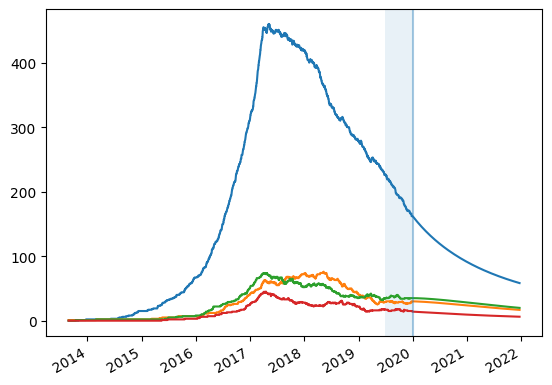

In [41]:
combined_pop.plot(legend=False)
pp.axvline(end_date, alpha=0.4)
pp.axvspan(start_date, end_date, alpha=0.1)
pp.show()

In [47]:
predictor = ModelPredictor.from_model(stats, start_date, end_date)

step_days = 90

predicted_pop = predictor.predict(720 // step_days, step_days=step_days, progress=True)  # Predict 720 days forward
historic_pop = stats.stock.loc[:end_date]
combined_pop = pd.concat([historic_pop, predicted_pop], axis=0)
combined_pop.columns = pd.MultiIndex.from_tuples(combined_pop.columns)

# Remove this to see individual sequences
combined_pop = combined_pop.groupby(level=1, axis=1).sum()
combined_pop

2021-12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.08it/s]


,FOSTERING,OTHER,RESIDENTIAL,SUPPORTED
2013-08-27,0.000000,1.000000,0.000000,0.000000
2013-08-28,0.000000,1.000000,0.000000,0.000000
2013-08-29,0.000000,1.000000,0.000000,0.000000
2013-08-30,0.000000,1.000000,0.000000,0.000000
2013-08-31,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...
2020-12-26,90.115341,24.569463,29.458198,10.251930
2021-03-26,79.921952,22.583016,27.127677,9.331572
2021-06-24,71.346236,20.668966,24.815110,8.484981
2021-09-22,64.048962,18.876176,22.595874,7.709968


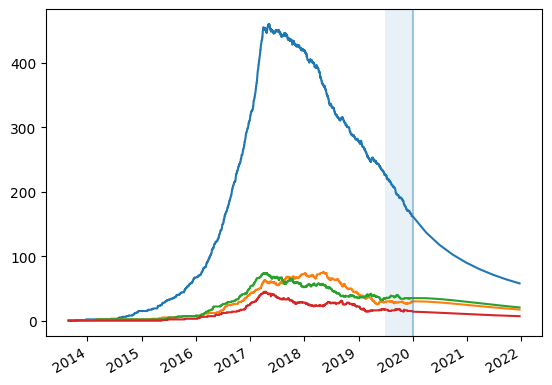

In [49]:
combined_pop.plot(legend=False)
pp.axvline(end_date, alpha=0.4)
pp.axvspan(start_date, end_date, alpha=0.1)
pp.show()